### Крапчатов Михаил Б05-131

# Задание 2: распознавание рукописных китайских иероглифов

## Описание

Предлагается реализовать и протестировать обучаемое распознавание символов на примере датасета `CASIA Offline Chinese Handwriting`

Данные можно взять [тут](https://disk.yandex.ru/d/xY5CBA77vwkVew), от оригинальных отличаются переводом формата из бинарного в lmdb. Лицензию на использование данных можно посмотреть на [официальном сайте](http://www.nlpr.ia.ac.cn/databases/handwriting/Application_form.html)

## Задача

Реализовать алгоритм распознавания китайских рукописных символов и протестировать его на данной тестовой выборке. Можно использовать как идеи с лекции, так и любые другие способы, которые покажутся вам уместными.

### Условия

- Разрешается использовать готовые реализации стандартных и нестандарных слоев или лоссов
- Разрешается использование дополнительных синтетических данных при обучении (псевдорукописные шрифты и прочее), однако способ их получения должен быть описан в решении
- Разрешается модифицировать ОБУЧАЮЩУЮ выборку любым способом, аугментации приветствуются. Тестовую выборку использовать кроме как для тестирования запрещено
- Запрещено использовать любые другие датасеты, а также альтернативные сплиты casia hwdb (в них часть тестовой выборки может оказаться в вашей обучающей)

## Метрика

Accuracy по результатам на тестовой выборке. Код для сохранения результата и локального вычисления метрики можно найти в `Baseline.ipynb`

Для работы автоматического подсчета метрики в github actions нужно закоммитить файл pred.txt в свой репозиторий. Если github actions не включены - включите их в `https://github.com/{USERNAME}/course_ocr/actions`

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

import cv2

import lightning
import tqdm
from tqdm.notebook import tqdm

from pathlib import Path
import os
from pynvml import *

In [3]:
# torch.device('cuda:0') if torch.cuda.is_available() else
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from matplotlib import pyplot as plt
plt.style.use("dark_background")

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else  torch.device("cpu")
print(f'device[{device.type}] with index[{device.index}]')

t = torch.cuda.get_device_properties(device.index).total_memory
r = torch.cuda.memory_reserved(device.index)
a = torch.cuda.memory_allocated(device.index)
f = r-a
nvmlInit()
h = nvmlDeviceGetHandleByIndex(device.index)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

device[cuda] with index[0]
total    : 11811160064
free     : 3172597760
used     : 8638562304


**Датасет**\
Скачал, распаковал датасет в папку, лежащую в папке с `.git` репозиторием. Далее команды из `Baseline.ipynb`. 

In [7]:
root = Path('../../lmdb').resolve()
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

In [8]:
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

In [9]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [10]:
train_helper, val_helper = train_helper.train_val_split()
train_helper.size(), val_helper.size()

(2578433, 644609)

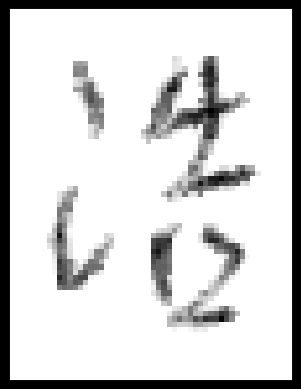

In [11]:
from matplotlib import pyplot as plt
img, label = train_helper.get_item(22)
# print(img)
plt.xticks([])
plt.yticks([])
plt.imshow(img, cmap='gray')

In [12]:
import torchvision

In [13]:
from PIL import Image
from torchvision import transforms
import numpy as np

**Небольшая обработка**\
Я оставлю приведение к одному `shape` только к болеевысокому разрешению (64,64) и
добавлю упрощение картинки: всего будет 3 цвета, где я буду красить лишь самые яркие
пиксели на картинке, мне кажется, это сделает работу модели более точной

In [55]:
class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper, img_sz=64):
        self.helper = helper
        # I think (32,32) is too inaccurate
        self.img_sz = img_sz
    
    def __len__(self):
        return self.helper.size()
        
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        img = (cv2.resize(img, (self.img_sz, self.img_sz)) - 127.5) / 255.

        # Simplification of colors in image
        # Simplify counters
        for y in range(len(img)):
            for x in range(len(img[0])):
                img[y][x] = np.float32(1 if img[y][x] > 0.12 else .1 if img[y][x] > -.05 else -1)
        return torch.tensor(img).to(device), torch.tensor(label).to(device)

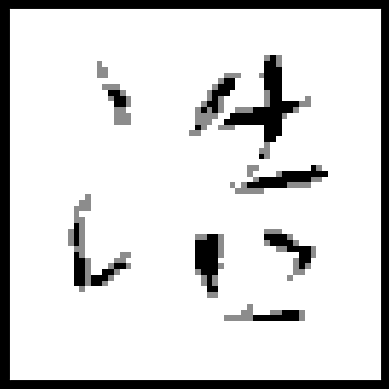

In [56]:
# from torch.utils.data.dataloader import default_collate
train_dataset = HWDBDataset(train_helper)
val_dataset   = HWDBDataset(val_helper)

batch_size = 1024
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True,  num_workers=0, drop_last=True)
val_dataloader   = DataLoader(val_dataset,   batch_size, shuffle=False, num_workers=0)
img = train_dataset[22][0]

plt.xticks([])
plt.yticks([])
plt.imshow(img.cpu(), cmap='gray')

## Работа с моделью

In [31]:
from torch import nn
from pytorch_metric_learning.losses import ArcFaceLoss
import torchvision
print(next(iter(train_dataloader))[0].device)

cuda:0


In [32]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
import gc
torch.cuda.empty_cache()
gc.collect()

880

Сперва попробовал `SGD`, но он сходился крайне медленно, поэтому решил переделать на Adam.

In [44]:
crit = ArcFaceLoss(num_classes=train_helper.vocabulary.num_classes(), embedding_size=1000).to(device)
net = torchvision.models.resnet50(train_helper.vocabulary.num_classes(),pretrained=True).to(device)
optim = torch.optim.Adam(params=net.parameters(), lr=1e-3)

In [45]:
from tqdm.notebook import tqdm

In [46]:
EPOCHS = 1
for epoch in tqdm(range(EPOCHS)):
    losses = []
    running_loss = 0
    print(f'dtloader len:{len(train_dataloader)}')
    for i, inp in tqdm(enumerate(train_dataloader)):
        x, y = inp
        x, y = x.to(device), y.to(device)
        optim.zero_grad()

        pred = net(x.unsqueeze(1).expand(-1, 3, -1, -1).type(torch.cuda.FloatTensor)).to(device)
        loss = crit(pred.to(device), y.to(device))
        losses.append(loss.item())

        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        
        if i%10 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
            
print('Training Done')

  0%|          | 0/1 [00:00<?, ?it/s]

dtloader len:2518


0it [00:00, ?it/s]

Loss [1, 10](epoch, minibatch):  4.52669734954834
Loss [1, 20](epoch, minibatch):  4.053141784667969
Loss [1, 30](epoch, minibatch):  4.0302237701416015
Loss [1, 40](epoch, minibatch):  4.0150054168701175
Loss [1, 50](epoch, minibatch):  4.000202407836914
Loss [1, 60](epoch, minibatch):  3.9889429092407225
Loss [1, 70](epoch, minibatch):  3.970701789855957
Loss [1, 80](epoch, minibatch):  3.951416015625
Loss [1, 90](epoch, minibatch):  3.9362102508544923
Loss [1, 100](epoch, minibatch):  3.9166698455810547
Loss [1, 110](epoch, minibatch):  3.891928863525391
Loss [1, 120](epoch, minibatch):  3.8644190979003907
Loss [1, 130](epoch, minibatch):  3.8380124282836916
Loss [1, 140](epoch, minibatch):  3.8108840560913086
Loss [1, 150](epoch, minibatch):  3.77370174407959
Loss [1, 160](epoch, minibatch):  3.749676475524902
Loss [1, 170](epoch, minibatch):  3.7158573913574218
Loss [1, 180](epoch, minibatch):  3.690536117553711
Loss [1, 190](epoch, minibatch):  3.653006134033203
Loss [1, 200](epo

In [47]:
%tensorboard --logdir tb_logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-05-13 17:26:24.796912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/krapchatovmi/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-05-13 17:26:24.796963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-13 17:26:26.665716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/krapchatovmi/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-05-13 17:26:26.665897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcu

### Evaluation

In [48]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=0)

In [49]:
net.to(device)
crit.to(device);

In [50]:
preds = []
net.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        xx = X.unsqueeze(1).expand(-1, 3, -1, -1)
        outputs = net(xx.to(device).type(torch.cuda.FloatTensor))
        
        logits = crit.get_logits(outputs)
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

  0%|          | 0/380 [00:00<?, ?it/s]

In [53]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [54]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9102190147619581